## Boosting (Decision Tree Approach)
The provided dataset contains a combination of quantitative and qualitative features, some of which may have non-linear relationships with the response variable. Boosting can handle these qualities well. In addition, boosting models learn slowly and attribute weight to important features, providing sufficient interpretability for the hospital board to learn from the model after it has been fitted.

In [3]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import the data set
df = pd.read_csv('FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv')
df.head()

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


In [5]:
# Manipulate and clean some of the data

# Create a column with procedure/condition name from measure name
df['Procedure'] = df['Measure Name'].str.extract(r'READM-30-(.*?)-HRRP')

# Make sure discharges and readmissions are numeric, cast all non-numeric responses (e.g. "N/A", "Too Few to Report") to NaN
df['Number of Readmissions'] = pd.to_numeric(df['Number of Readmissions'], errors='coerce')
df['Number of Discharges'] = pd.to_numeric(df['Number of Discharges'], errors='coerce')

# Aggregare to get total readmissions and discharges
readmission_sum = df.groupby('Facility ID')[['Number of Readmissions', 'Number of Discharges']].sum().reset_index()
readmission_sum.rename(columns={
    'Number of Readmissions': 'Total Readmissions',
    'Number of Discharges': 'Total Discharges'
}, inplace=True)

# Pivot to get number of discharges by procedure name
discharges_by_type = df.pivot_table(
    index='Facility ID',
    columns='Procedure',
    values='Number of Discharges'
).reset_index()

discharges_by_type.columns.name = None

hospital_df = pd.merge(readmission_sum, discharges_by_type, on='Facility ID', how='left')
hospital_df['Readmission Rate'] = hospital_df['Total Readmissions'] / hospital_df['Total Discharges']

hospital_df = hospital_df.dropna()

print(hospital_df.shape)
hospital_df.head()

(115, 10)


,Facility ID,Total Readmissions,Total Discharges,AMI,CABG,COPD,HF,HIP-KNEE,PN,Readmission Rate
19,10039,612.0,4095.0,624.0,267.0,426.0,1270.0,168.0,1340.0,0.149451
53,10104,276.0,1797.0,207.0,112.0,154.0,598.0,385.0,341.0,0.153589
90,30006,323.0,2026.0,282.0,114.0,167.0,652.0,251.0,560.0,0.159427
119,30087,333.0,2068.0,286.0,119.0,111.0,692.0,229.0,631.0,0.161025
126,30103,388.0,2421.0,218.0,90.0,128.0,919.0,187.0,879.0,0.160264


In [6]:
class DecisionTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = {}

    def fit(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1:
            self.tree = np.mean(y)
            return
        
        best_feature, best_threshold = self.find_best_split(X, y)
        
        if best_feature is None:
            self.tree = np.mean(y)
            return
        
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        self.tree = {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': DecisionTree(max_depth=self.max_depth),
            'right': DecisionTree(max_depth=self.max_depth)
        }
        
        self.tree['left'].fit(X[left_indices], y[left_indices], depth + 1)
        self.tree['right'].fit(X[right_indices], y[right_indices], depth + 1)

    def find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            unique_values = np.unique(X[:, feature])
            for threshold in unique_values:
                left_indices = X[:, feature] <= threshold
                right_indices = ~left_indices
                
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                
                gain = self.information_gain(y, y[left_indices], y[right_indices])
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold

    def information_gain(self, parent, left_child, right_child):
         # Calculate variance reduction as the information gain
        parent_variance = np.var(parent) if len(parent) > 0 else 0
        left_variance = np.var(left_child) if len(left_child) > 0 else 0
        right_variance = np.var(right_child) if len(right_child) > 0 else 0
    
        n_left = len(left_child)
        n_right = len(right_child)
        n_total = len(parent)
    
        gain = parent_variance - (n_left / n_total) * left_variance - (n_right / n_total) * right_variance
        return gain

    def predict(self, X):
        if isinstance(self.tree, (int, float)):
            return np.full(len(X), self.tree)
        
        predictions = np.empty(len(X))
        
        for i, x in enumerate(X):
            node = self.tree
            while isinstance(node, dict):
                if x[node['feature']] <= node['threshold']:
                    node = node['left'].tree
                else:
                    node = node['right'].tree
            predictions[i] = node
        return predictions
    
    def print_tree(self, node=None, depth=0, prefix="", feature_names=None, is_last=True):
        if node is None:
            node = self.tree

        indent = "    " * (depth - 1) + ("└── " if is_last else "├── ") if depth > 0 else ""
        
        if isinstance(node, dict):
            feature_idx = node['feature']
            feature = feature_names[feature_idx] if feature_names else f"feature[{feature_idx}]"
            threshold = node['threshold']

            print(f"{indent}{feature} <= {threshold:.4f}")
            # Left child (True)
            self.print_tree(node['left'].tree, depth + 1, prefix, feature_names, is_last=False)
            # Right child (False)
            self.print_tree(node['right'].tree, depth + 1, prefix, feature_names, is_last=True)
        else:
            print(f"{indent}return {node:.4f}")


In [7]:
class Boosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.losses = []

    def fit(self, X, y):
         # Initialize predictions with the mean of the target variable
        self.initial_prediction = np.mean(y)
        predictions = np.full(len(y), self.initial_prediction)
        
        for _ in range(self.n_estimators):
            # Calculate residuals (negative gradient of the mean squared error loss)
            residuals = y - predictions
            
            # Fit a decision tree to the residuals
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            # Update predictions
            predictions += self.learning_rate * tree.predict(X)
            
            # Store the tree
            self.trees.append(tree)

            mse = np.mean(residuals ** 2)
            self.losses.append(mse)

    def predict(self, X):
        # Initialize predictions with the initial prediction
        predictions = np.full(len(X), self.initial_prediction)
        
        # Add predictions from each tree
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions

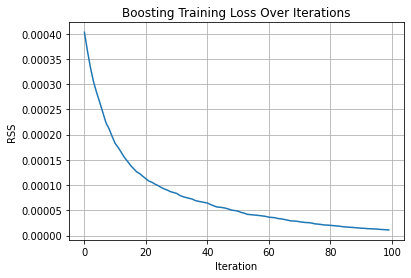

HIP-KNEE <= 260.0000
├── AMI <= 175.0000
    ├── AMI <= 81.0000
        ├── return 0.0236
        └── return 0.0492
    └── COPD <= 202.0000
        ├── return 0.0064
        └── return 0.0189
└── COPD <= 330.0000
    ├── HIP-KNEE <= 422.0000
        ├── return -0.0023
        └── return -0.0161
    └── HIP-KNEE <= 1102.0000
        ├── return 0.0188
        └── return -0.0164
Final training error: 1.1102994219720483e-05


In [11]:
# Split data into predictors and response
X = hospital_df[['AMI', 'CABG',	'COPD',	'HF', 'HIP-KNEE', 'PN']]
X = X.to_numpy()
y = hospital_df['Readmission Rate'].values

model = Boosting()
model.fit(X, y)

plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('RSS')
plt.title('Boosting Training Loss Over Iterations')
plt.grid(True)
plt.show()

model.trees[0].print_tree(feature_names=['AMI', 'CABG', 'COPD', 'HF', 'HIP-KNEE', 'PN']) 
print("Final training error:", model.losses[-1])

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Boosting()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    mse_scores.append(mse)

print(f"Test error: {np.mean(mse_scores):.4f}")

Test error: 0.0003
